# Load a pretrained model

In [51]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

# Load an image

In [ ]:
img_path = '/media/shuvendu/Projects/Datasets/Cat_and_Dog_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
print(type(img))


In [ ]:
img_tensor = image.img_to_array(img)
print(type(img_tensor))
print(img_tensor.shape)

In [ ]:
# add one more dimension for batchsize
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

# Display the image

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])

# Instantiating a model from an input tensor and a list of output tensors

In [ ]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Running the model in predict mode

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

# Visualizing specific channel

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 27], cmap='viridis')

# Visualizing convnet filters

In [53]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [55]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:, filter_index])

To implement gradient descent, you’ll need the gradient of this loss with respect to
the model’s input. To do this, you’ll use the gradients function packaged with the
backend module of Keras.

## Obtaining the gradient of the loss with regard to the input

In [56]:
grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average
of the square of the values in the tensor). This ensures that the magnitude of the
updates done to the input image is always within the same range.

## Gradient-normalization trick

In [57]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

## Fetching numpy output values given Numpy input

In [58]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [59]:
loss_value

0.0

In [60]:
grads_value.shape

(1, 150, 150, 3)

## Loss maximization via stochastic gradient descent

In [61]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

step = 1
for i in range(40):
    loss_value, grad_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

## Utility function to convert a tensor into a valid image

In [62]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to generate filter visualization

In [63]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

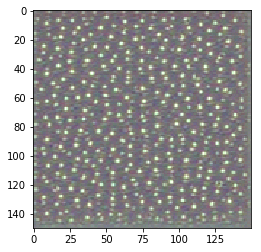

In [64]:
plt.imshow(generate_pattern('block3_conv1', 0))

# Visualize all layers

In [ ]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [ ]:
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    
plt.figure(figsize=(20, 20))
plt.imshow(results)

In [10]:
from scipy.misc import imsave
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'block5_conv1'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(100):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n +1 ]  # Keeping one more different looking image from other

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j+1]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

Current loss value: 10.3515
Current loss value: 42.5354
Current loss value: 68.6231
Current loss value: 97.0246
Current loss value: 155.879
Current loss value: 233.649
Current loss value: 299.331
Current loss value: 342.407
Current loss value: 366.7
Current loss value: 449.533
Current loss value: 476.608
Current loss value: 527.916
Current loss value: 583.375
Current loss value: 613.623
Current loss value: 669.102
Current loss value: 701.24
Current loss value: 721.036
Current loss value: 779.953
Current loss value: 794.377
Current loss value: 853.691
Filter 9 processed in 1s
Processing filter 10
Current loss value: 10.1763
Current loss value: 12.3198
Current loss value: 38.0408
Current loss value: 79.5519
Current loss value: 109.779
Current loss value: 134.37
Current loss value: 196.062
Current loss value: 235.636
Current loss value: 286.655
Current loss value: 317.043
Current loss value: 353.682
Current loss value: 404.165
Current loss value: 437.902
Current loss value: 480.472
Curren

Current loss value: 1.21497
Current loss value: 29.2503
Current loss value: 77.2731
Current loss value: 139.594
Current loss value: 195.199
Current loss value: 240.383
Current loss value: 283.914
Current loss value: 333.857
Current loss value: 379.349
Current loss value: 424.744
Current loss value: 465.669
Current loss value: 507.029
Current loss value: 548.149
Current loss value: 587.046
Current loss value: 631.187
Current loss value: 669.347
Current loss value: 709.402
Current loss value: 746.827
Current loss value: 784.918
Current loss value: 822.993
Filter 28 processed in 1s
Processing filter 29
Current loss value: 39.2878
Current loss value: 54.7649
Current loss value: 113.286
Current loss value: 151.049
Current loss value: 234.079
Current loss value: 296.453
Current loss value: 344.193
Current loss value: 406.471
Current loss value: 456.245
Current loss value: 516.115
Current loss value: 558.279
Current loss value: 611.824
Current loss value: 665.5
Current loss value: 718.636
Cur

Current loss value: 490.514
Current loss value: 521.375
Current loss value: 556.405
Current loss value: 588.958
Current loss value: 622.228
Current loss value: 656.306
Current loss value: 689.923
Filter 44 processed in 1s
Processing filter 45
Current loss value: 0.0
Filter 45 processed in 1s
Processing filter 46
Current loss value: 0.972774
Current loss value: 7.95624
Current loss value: 24.6353
Current loss value: 67.4224
Current loss value: 123.655
Current loss value: 185.201
Current loss value: 250.042
Current loss value: 318.905
Current loss value: 379.824
Current loss value: 446.691
Current loss value: 508.71
Current loss value: 566.172
Current loss value: 619.138
Current loss value: 674.76
Current loss value: 726.415
Current loss value: 779.559
Current loss value: 835.26
Current loss value: 892.363
Current loss value: 947.704
Current loss value: 1003.22
Filter 46 processed in 1s
Processing filter 47
Current loss value: 2.78091
Current loss value: 79.8914
Current loss value: 218.5

Current loss value: 950.101
Current loss value: 1007.16
Current loss value: 1049.87
Filter 61 processed in 1s
Processing filter 62
Current loss value: 8.19287
Current loss value: 83.8071
Current loss value: 139.435
Current loss value: 188.757
Current loss value: 225.324
Current loss value: 271.085
Current loss value: 314.017
Current loss value: 353.986
Current loss value: 399.837
Current loss value: 449.473
Current loss value: 493.211
Current loss value: 546.212
Current loss value: 595.122
Current loss value: 643.299
Current loss value: 687.578
Current loss value: 726.279
Current loss value: 772.427
Current loss value: 809.524
Current loss value: 851.163
Current loss value: 880.914
Filter 62 processed in 1s
Processing filter 63
Current loss value: 0.0
Filter 63 processed in 1s
Processing filter 64
Current loss value: 0.0
Filter 64 processed in 1s
Processing filter 65
Current loss value: 31.5194
Current loss value: 62.7052
Current loss value: 100.124
Current loss value: 136.54
Current l

Current loss value: 1141.11
Current loss value: 1194.36
Current loss value: 1247.82
Filter 82 processed in 1s
Processing filter 83
Current loss value: 0.0
Filter 83 processed in 1s
Processing filter 84
Current loss value: 10.1149
Current loss value: 10.1474
Current loss value: 28.1713
Current loss value: 52.5491
Current loss value: 100.259
Current loss value: 155.91
Current loss value: 168.994
Current loss value: 213.847
Current loss value: 267.839
Current loss value: 312.96
Current loss value: 337.458
Current loss value: 382.265
Current loss value: 441.081
Current loss value: 471.821
Current loss value: 508.129
Current loss value: 578.581
Current loss value: 611.744
Current loss value: 645.936
Current loss value: 700.836
Current loss value: 734.921
Filter 84 processed in 1s
Processing filter 85
Current loss value: 0.0
Filter 85 processed in 1s
Processing filter 86
Current loss value: 7.99923
Current loss value: 16.0687
Current loss value: 55.1376
Current loss value: 128.493
Current lo

c:\users\bikas\anaconda3\lib\site-packages\ipykernel\__main__.py:127: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
